<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Irina Knyazeva, ODS Slack nickname : iknyazeva
    
## <center> Tutorial
### <center> "HANDLE DIFFERENT DATASET WITH DASK AND TRYING A LITTLE DASK ML"

## WHY DO I NEED DASK?

Dask provides high-level Array, Bag, and DataFrame collections that mimic NumPy, lists, and Pandas but can operate in parallel on datasets that don’t fit into main memory. Dask’s high-level collections are alternatives to NumPy and Pandas for large datasets.

## YOU DEFINITELY NEED DASK  IF
if problem size close to limits of RAM, but fits to disk


## Reading list
This notebook based mainly  based on this three sources

- [One more tutorial from analytics vidhya](https://www.analyticsvidhya.com/blog/2018/08/dask-big-datasets-machine_learning-python/)
- [taken from towardsdatascience](https://towardsdatascience.com/trying-out-dask-dataframes-in-python-for-fast-data-analysis-in-parallel-aa960c18a915)

- [DataCamp course](https://campus.datacamp.com/courses/parallel-computing-with-dask/)

- [Dask documentation](https://docs.dask.org/en/latest/) 




In [2]:
import gc
import os
import time
import warnings

import numpy as np
import pandas as pd
import psutil
from dask import delayed

warnings.filterwarnings("ignore")

Let's  write a little function for tracking memory that takes python process

In [3]:
def memory_footprint():
    mem = psutil.Process(os.getpid()).memory_info().rss
    return mem / 1024 ** 2

In [4]:
before = memory_footprint()
print(f"Memory used before is {round(before,2)} MB")

Memory used before is 60.67 MB


In [5]:
N = (1024 ** 2) // 8
x = np.random.randn(50 * N)
after = memory_footprint()
print(f"Memory used after is {round(after,2)} MB")

Memory used after is 110.9 MB


Computes, but doesn't bind result to a variable allocate extra memory

In [6]:
x ** 2
after1 = memory_footprint()
print(f" Extra memory obtained after computation {round(after1,2)} MB")

 Extra memory obtained after computation 161.0 MB


## Dask arrays

Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs.[dask array documentation](http://docs.dask.org/en/latest/array.html)



<center>
<img src="http://docs.dask.org/en/latest/_images/dask-array-black-text.svg" />
In dask there is three main structures: dask array (based on numpy array), dask dataframe (based on pandas dataframe)  and dask bags (for unstructured data as text).

In [7]:
import dask.array as da

y = da.from_array(x, chunks=len(x) // 4)
print("Dask arrays require little memory:", memory_footprint() - after1)

Dask arrays require little memory: 50.7421875


In [8]:
import time

t_start = time.time()
x.mean()
t_end = time.time()
print("Compute mean value of this numpy array \n")
print(
    "Elapsed time for compute mean of numpy array (ms):",
    round((t_end - t_start) * 1000),
)

Compute mean value of this numpy array 

Elapsed time for compute mean of numpy array (ms): 5


In [9]:
t_start = time.time()
y.mean().compute()
t_end = time.time()
print("Compute the same with dask \n")
print(
    "Elapsed time for compute mean of dask array (ms):", round((t_end - t_start) * 1000)
)

Compute the same with dask 

Elapsed time for compute mean of dask array (ms): 827


Actually, this example will never be used in practice, because if your numpy already in memory, any partitioning will always raise computational time. But if you need to process data from HDF5, NetCDF or bulk of numpy files from disk it could be extremely useful

## Delayed operations with dask

But dask could be useful for small data with delayed computation. It could easily parallelize computation. Let's see the example with our previous numpy array   

In [10]:
def f(z):
    return np.sqrt(z + 4)


def g(y):
    return y - 3


def h(x):
    return x ** 2


time_start = time.time()
x = np.random.randn(50 * N)
y = h(x)
z = g(x)
w = f(z + y)
time_end = time.time()
print(
    "Elapsed time for compute complex functions with numpy array (ms):",
    round((time_end - time_start) * 1000),
)

Elapsed time for compute complex functions with numpy array (ms): 505


In [11]:
y = delayed(h)(x)
z = delayed(g)(x)
w = delayed(f)(z + y)
print("After we get dask delayed object", w)
time_start = time.time()
w.compute()
time_end = time.time()
print(
    "Elapsed time for compute complex functions with numpy array with dask delayed (ms):",
    round((time_end - time_start) * 1000),
)

After we get dask delayed object Delayed('f-1c619143-5ccd-465c-88c5-b3561a3bf03d')
Elapsed time for compute complex functions with numpy array with dask delayed (ms): 138


It is easily understood why computation time decreased with the computational graph. Let's do this with the second way of introducing delay functions

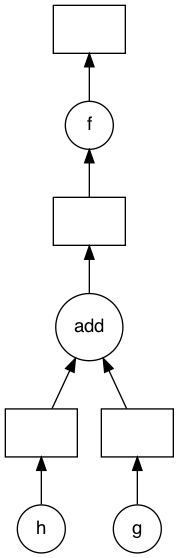

In [12]:
@delayed
def f(z):
    return np.sqrt(z + 4)


@delayed
def g(y):
    return y - 3


@delayed
def h(x):
    return x ** 2


y = h(x)
z = g(x)
w = f(z + y)
w.visualize()

## Dask dataframe 

Dask DataFrames coordinate many Pandas DataFrames/Series arranged along the index. A Dask DataFrame is partitioned row-wise, grouping rows by index value for efficiency. These Pandas objects may live on disk or on other machines.
(See documentation)[http://docs.dask.org/en/latest/dataframe.html]

<center>
<img src="http://docs.dask.org/en/latest/_images/dask-dataframe.svg" width="40%" height="40% />


Here we use the file `athlete_events.csv` from [this Kaggle Dataset](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results)

In [13]:
import dask.dataframe as dd

In [16]:
print("Let's return to start of our ML journey\n")
print("Load olympic dataset \n")
PATH = "../../jupyter_english/tutorials/data/athlete_events.csv"

Let's return to start of our ML journey

Load olympic dataset 



In [17]:
df = pd.read_csv(PATH)
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [27]:
m1 = memory_footprint()
dask_df = dd.read_csv(PATH,dtype={'Age': 'float64'})
m2 = memory_footprint()
print("Dask do not allocate memory after creation:", m2 - m1)

Dask do not allocate memory after creation: -16.26171875


In [28]:
print("But we could see data as in pandas dataframe:")
dask_df.head()


But we could see data as in pandas dataframe:


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [29]:
# building delayed  computation
print(
    "We can do many operation the same way as in pandas, but without loading all data in memory \n "
)
sex_distr = (
    dask_df.loc[dask_df["Games"].str.contains("1996")].groupby("Sex")["Age"].min()
)

We can do many operation the same way as in pandas, but without loading all data in memory 
 


In [30]:
print(
    "Here we done selecting and aggregation exactly the same way as we did in pandas \n"
)
print("But there is not any computation, we create dask structure \ n")
sex_distr

Here we done selecting and aggregation exactly the same way as we did in pandas 

But there is not any computation, we create dask structure \ n


Dask Series Structure:
npartitions=1
    float64
        ...
Name: Age, dtype: float64
Dask Name: series-groupby-min-agg, 7 graph layers

In [31]:
%%time
print(
    "Computation is time consuming, but we remember that we dont't need to load all data in memory for this computation \n"
)
print(sex_distr.compute())

Computation is time consuming, but we remember that we dont't need to load all data in memory for this computation 

Sex
F    12.0
M    14.0
Name: Age, dtype: float64
CPU times: user 760 ms, sys: 162 ms, total: 922 ms
Wall time: 1.22 s


In [32]:
%%time
print("Pandas of course more effective \n")
print(df.loc[df["Games"].str.contains("1996")].groupby("Sex")["Age"].min())

Pandas of course more effective 

Sex
F    12.0
M    14.0
Name: Age, dtype: float64
CPU times: user 165 ms, sys: 59.3 ms, total: 224 ms
Wall time: 279 ms


### Compatibility with Pandas API
- Unavailable in dask.dataframe:
    * some unsupported file formats (e.g., .xls, .zip,...)
    * sorting
- Available in dask.dataframe:
    * indexing, selection, & reindexing
    * aggregations: .sum(), .mean(), .std(), .min(), .max() etc.
    * grouping with .groupby()
    * datetime conversion with dd.to_datetime()

### Read collections of files to dask dataframe
For example I've taken Alica Project.  Capstone_user_identification archive [link](https://drive.google.com/open?id=1AU3M_mFPofbfhFQa_Bktozq_vFREkWJA) (~7 Mb, unziped data ~60 Mb).


In [ ]:
PATH_TO_DATA = "../../data/capstone_user_identification"

In [ ]:
print("We can load all files in single dataframe \n")
print("Your dont't need this in Alica project, just an example \n ")
user10dask = dd.read_csv(os.path.join(PATH_TO_DATA, "10users/*.csv"))

In [ ]:
print("We can look at the data")
print(user10dask)
user10dask.tail()

In [ ]:
print(
    "Let's see what happens if we want to count all sites (it could seen as a one more way for dictionary creation) \n"
)
count_sites = user10dask.groupby("site")["site"].count()

In [ ]:
print("If we visualize this structure we'll see the picture of computation \n")
count_sites.visualize()

In [ ]:
%%time
count_sites.compute().sort_values(ascending=False)[:20]

## JSON Files into Dask Bags

Dask Bag implements operations like map, filter, fold, and groupby on collections of Python objects. It does this in parallel with a small memory footprint using Python iterators. It is similar to a parallel version of PyToolz or a Pythonic version of the PySpark RDD.[Dask bag documentation](http://docs.dask.org/en/latest/bag-overview.html)


Dask bags are often used to parallelize simple computations on unstructured or semi-structured data like text data, log files, JSON records, or user defined Python objects.
 
Let's see example with our Medium data from [this competition](https://www.kaggle.com/c/how-good-is-your-medium-article/data).


In [ ]:
import json

import dask.bag as db

In [ ]:
print("Path to our medium data \n")
PATH = "../../data/kaggle_medium"
print(PATH)

In [ ]:
print("Wrap train json to dask bag format \n")
items = db.read_text(os.path.join(PATH, "train.json"))
items

In [ ]:
%%time
print("Let's look at one example \n")
print(items.take(1))

In [ ]:
print("We can parse date with json library and get dict like object \n")
dict_items = items.map(json.loads)
print(type(dict_items))

In [ ]:
dict_items.take(1)

In [ ]:
print("We can take any key from all records \n")
title_bag = dict_items.pluck("title")
print("With take method we received tuple of objects \n")
print(title_bag.take(3))

We can write any function for processing data and apply it with map function

In [ ]:
def clean_title(text):

    import string

    cut_set = set(string.punctuation)
    cut_set.update(["”", "—", "…", "“", "⌘", "❤", "+", "®", "➜", "¬", "–"])
    text = text.translate(text.maketrans("".join(cut_set), " " * len(cut_set)))
    text = text.lower()
    return text

In [ ]:
title_bag = dict_items.pluck("title").map(clean_title)

In [ ]:
title_bag.take(3)

Process  meta_tags

In [ ]:
meta_tags_bag = dict_items.pluck("meta_tags")
test_meta = meta_tags_bag.take(3)

In [ ]:
test_meta[1]

In [ ]:
def clean_meta_tags(meta):
    author = meta["author"].strip()
    min_reads = int(meta["twitter:data1"].split()[0])
    return {"author": author, "min_reads": min_reads}

In [ ]:
meta_tags_bag = meta_tags_bag.map(clean_meta_tags)

In [ ]:
meta_tags_bag.take(1)

### Combine all together

In [ ]:
%%time
# content_bag = dict_items.pluck('content').map(clean_content)
title_bag = dict_items.pluck("title").map(clean_title)
published_bag = dict_items.pluck("published").map(lambda x: x["$date"])
meta_bag = dict_items.pluck("meta_tags").map(clean_meta_tags)
domain_bag = dict_items.pluck("domain")

In [ ]:
@delayed
def combine_to_df(list_dict):

    list_df = [pd.DataFrame(dict_) for dict_ in list_dict]
    return pd.concat(list_df, axis=1)

In [ ]:
combined = combine_to_df([published_bag, meta_bag, domain_bag])
combined.visualize()

In [ ]:
# It takes time, around a minute
from dask.diagnostics import ProgressBar

with ProgressBar():
    df = combined.compute()
df.columns = ["published", "Author", "min_reads", "domain"]
df.head()

In [ ]:
print("We can create dask dataframe from pandas \n")
dd_no_content = dd.from_pandas(df, npartitions=4)

In [ ]:
dd_no_content

In [ ]:
%%time
print(
    "Transform published column to datetime as we did with pandas, it will by slightly slowly than in pandas \n"
)
df["published"] = pd.to_datetime(df.published, format="%Y-%m-%dT%H:%M:%S.%fZ")

In [ ]:
%%time
print("Transform published column to datetime  with pandas, \n")
dd_no_content["published"] = dd.to_datetime(
    dd_no_content.published, format="%Y-%m-%dT%H:%M:%S.%fZ"
).compute()

In [ ]:
dd_no_content.head()

In [ ]:
print(
    "We can apply function with mixed transformation to dask dataframe written for pandas df without changes \n"
)


def additional_time_features_df(
    df, to_cat_cols=["Author", "domain", "month", "year", "day_of_week"]
):

    df["month"] = df["published"].apply(lambda ts: ts.month)
    df["year"] = df["published"].apply(lambda ts: ts.year)
    hour = df["published"].apply(lambda ts: ts.hour)
    df["hour"] = hour
    df["morning"] = ((hour >= 7) & (hour <= 11)).astype("float64")
    df["day"] = ((hour >= 12) & (hour <= 18)).astype("int")
    df["evening"] = ((hour >= 19) & (hour <= 23)).astype("int")
    df["night"] = ((hour >= 0) & (hour <= 6)).astype("int")
    df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)
    df = df.drop(["hour"], axis=1)
    day_of_week = df["published"].dt.dayofweek.astype("int")
    df["day_of_week"] = day_of_week
    df["weekend"] = (day_of_week >= 5).astype("int")
    # turn to categorical
    df[to_cat_cols] = df[to_cat_cols].astype("category")

    return df

In [ ]:
%%time
df_medium_train = additional_time_features_df(df.copy())

In [ ]:
dd_medium_train = additional_time_features_df(dd_no_content)

In [ ]:
%%time
dd_medium_train.compute()

## Dask ML

Dask ML provides scalable machine learning algorithms in python which are compatible with scikit-learn. Let us first understand how scikit-learn handles the computations and then we will look at how Dask performs these operations differently. See dask-ml tutorials: [Examples from dask ml](http://ml.dask.org/examples.html)

You need to install dask-ml at first 

There are two main parts in dask ml:
    - approaches to handle big datasets 
    - approaches to handle big models

### Handle big model with dask distributed
The biggest model from our course was a random forest on text data in the week with Random Forest assignment. Below I just reproduce part of our assignment, but  I reduced nrows and max features in Count vectorizer, but you can check with original parameters.

Here we use the [`movie_reviews_train.csv`](https://drive.google.com/file/d/1WDz3EB0MMuQUuUTwZ30c4JJrN8d9shAW/view?usp=sharing) file.

In [ ]:
# Download data
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=5000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline(
    [
        ("vectorizer", CountVectorizer(max_features=500, ngram_range=(1, 3))),
        ("clf", LogisticRegression(random_state=17)),
    ]
)

In [ ]:
%%time
parameters = {"clf__C": (0.1, 1, 10, 100)}
grid_search = GridSearchCV(classifier, parameters, scoring="roc_auc", cv=skf)
grid_search = grid_search.fit(X_text, y_text)

In [ ]:
grid_search.best_score_

### Replace joblib with dask

In this approach all we need to do is replace joblib to dask distributed. We need to initialize distributed client, and change backend

In [ ]:
from dask.distributed import Client
%%time
from sklearn.externals import joblib

client = Client()
parameters = {"clf__C": (0.1, 1, 10, 100)}
grid_search = GridSearchCV(classifier, parameters, scoring="roc_auc", cv=skf)

t_start = time.time()

with joblib.parallel_backend("dask"):
    grid_search.fit(X_text, y_text)
t_end = time.time()
print("Elapsed time for grid_search with joblib replace (s):", round((t_end - t_start)))

In [ ]:
grid_search.best_score_

### Replace Grid search with dask
Parallel to Gridsearch CV in sklearn, Dask provides a library called Dask-search CV (Dask-search CV is now included in Dask ML). It merges steps so that there are less repetitions. Below are the installation steps for Dask-search. We need to install it separately

In [ ]:
# pip3 install dask-searchcv
import dask_searchcv as dcv

We can use a pipelines in dask grid search, and according the documentation we should use dask with pipelines with many opeations which could be parallelized, especially included feature union, but I've tried and get an error as a result... Anyway time consuming operations as CountVectorizer couldn't be parallelized, so here gridsearch from dask  only for classifier [documentation](https://dask-searchcv.readthedocs.io/en/latest/). 

In [ ]:
%%time
vect = CountVectorizer(max_features=500, ngram_range=(1, 3))
Xvect = vect.fit_transform(X_text)

In [ ]:
lr = LogisticRegression()
parameters = {"C": (0.1, 1, 10, 100)}
t_start = time.time()
grid_search = dcv.GridSearchCV(lr, parameters, scoring="roc_auc", cv=skf)
grid_search.fit(Xvect, y_text)
t_end = time.time()
print(
    f"Elapsed time for grid_search (without time spended to vectorization) {round((t_end - t_start))} (s):"
)

In [ ]:
grid_search.best_score_

I tried to see how good dask will be with random forest with original parameters, but sometimes this raise en error get "(OSError: [Errno 24] Too many open files) after execution, and I couldn't fix it...."  Sometimes it works ok, for small data it works in most cases, but if you re-run this notebook several times there is a big chance to get such an error. So, I believe that dask-ml very usefull, but for know I definitely don't know how it should be used properly. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=17)
min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

parameters = {
    "max_features": max_features,
    "min_samples_leaf": min_samples_leaf,
    "max_depth": max_depth,
}
grid_search = dcv.GridSearchCV(rf, parameters, scoring="roc_auc", cv=skf)
t_start = time.time()
grid_search.fit(Xvect, y_text)
t_end = time.time()
print(
    f"Elapsed time for dask grid_search for Random Forest {round((t_end - t_start))} (s):"
)

### Handle model with big data
There are number of models rewritten in dask, which could take dask object (huge arrays) and compute models on them. You could read more in dask documentation. Below an example with KMeans, but also there are dask version of linear models, processing functions. The notation is very similar to scikit-learn, and it should be easy to use. 

In [ ]:
from dask_ml import datasets
from dask_ml.cluster import KMeans

In [ ]:
X, y = datasets.make_blobs(
    n_samples=10000000, chunks=1000000, random_state=0, centers=3
)
# Persist will give you back a lazy dask.delayed object
X = X.persist()
X

In [ ]:
km = KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

Actually I read the article about dask couple of days ago and I've decided that task with tutorial a good way to get acquainted with the library. So I ask  you not to be very strict if  I misunderstood something:))